# Segmentação de clientes

Usar o algoritmo K-Means para agrupar clientes com base em seus comportamentos de compra. Descrever as características de cada grupo.

## Instalação de bibliotecas

In [7]:
%pip install pandas matplotlib seaborn sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

## Importação das tabelas

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Carregar os datasets
customers = pd.read_csv("olist_customers_dataset.csv")
geolocation = pd.read_csv("olist_geolocation_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
order_payments = pd.read_csv("olist_order_payments_dataset.csv")
order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
product_category_translation = pd.read_csv("product_category_name_translation.csv")

## Preparação dos dados (RFV)

In [9]:
# Calcula o valor total de cada pedido
order_items['total_value'] = order_items['price'] + order_items['freight_value']
order_totals = order_items.groupby('order_id')['total_value'].sum().reset_index()
orders = pd.merge(orders, order_totals, on='order_id', how='left')


# Converte a data de compra para datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Define a data mais recente como um dia após a última compra
most_recent_date = orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

# Calcula a Recência, Frequência e Valor Monetário (RFV)
rfv = orders.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (most_recent_date - x.max()).days,  # Recência
    'order_id': 'count',  # Frequência
    'total_value': 'sum'  # Valor Monetário
})

rfv.rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'total_value': 'MonetaryValue'
}, inplace=True)

print(rfv.head())



# Padroniza os dados (importante para o K-Means)
scaler = StandardScaler()
rfv_scaled = scaler.fit_transform(rfv)

                                  Recency  Frequency  MonetaryValue
customer_id                                                        
00012a2ce6f8dcda20d059ce98491703      338          1         114.74
000161a058600d5901f007fab4c27140      459          1          67.41
0001fd6190edaaf884bcaf3d49edf079      597          1         195.42
0002414f95344307404f0ace7a26f1d5      428          1         179.35
000379cdec625522490c315e70c7a9fb      199          1         107.01


## Aplicando o K-Means

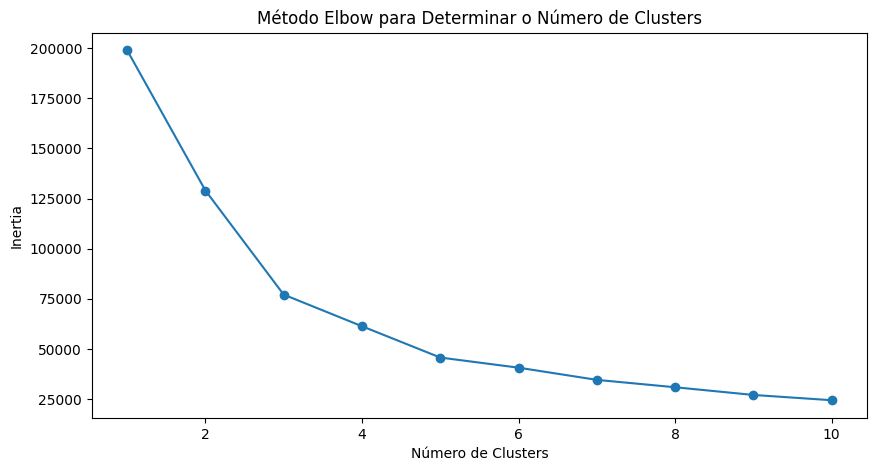

                                  Recency  Frequency  MonetaryValue  Cluster
customer_id                                                                 
00012a2ce6f8dcda20d059ce98491703      338          1         114.74        1
000161a058600d5901f007fab4c27140      459          1          67.41        1
0001fd6190edaaf884bcaf3d49edf079      597          1         195.42        1
0002414f95344307404f0ace7a26f1d5      428          1         179.35        1
000379cdec625522490c315e70c7a9fb      199          1         107.01        0


In [10]:
# Determina o número ideal de clusters (método Elbow)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(rfv_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método Elbow para Determinar o Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()

# Escolhe o número de clusters baseado no gráfico do Elbow (exemplo: 4 clusters)
n_clusters = 4 # modifique se o gráfico elbow indicar outro valor ideal

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rfv['Cluster'] = kmeans.fit_predict(rfv_scaled)

print(rfv.head())

## Analisando os Clusters


Características dos Clusters:
            Recency        Frequency        MonetaryValue         
               mean median      mean median          mean   median
Cluster                                                           
0        179.519870  181.0       1.0    1.0    118.238119    99.14
1        442.008264  430.0       1.0    1.0    118.952898    96.12
2        297.415816  283.0       1.0    1.0   1819.093431  1589.91
3        275.690562  263.5       1.0    1.0    608.856138   558.52


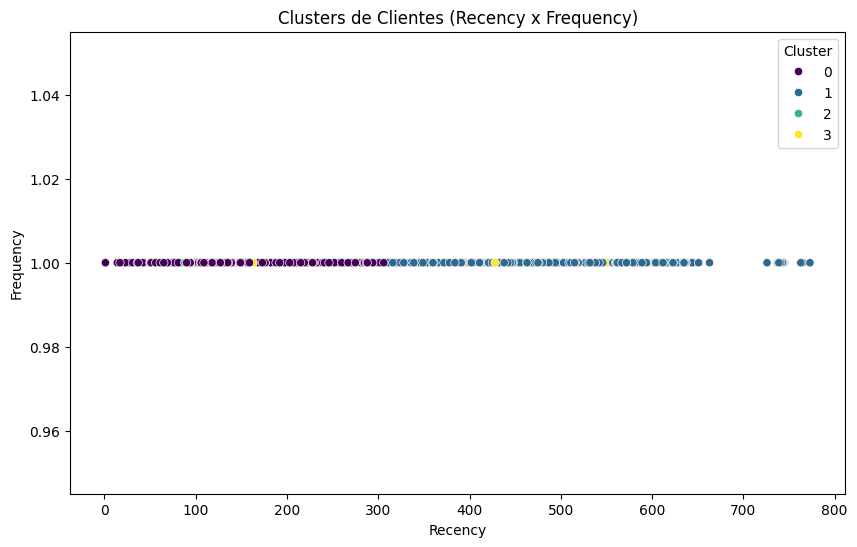

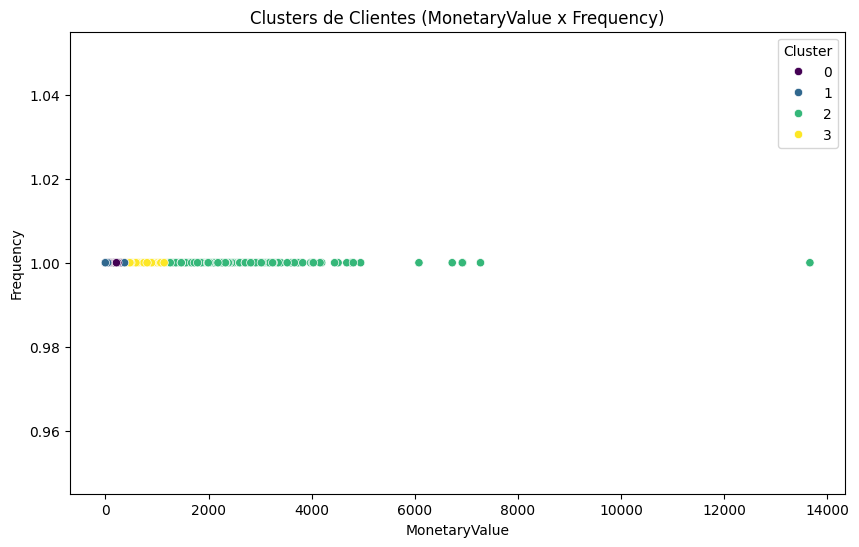

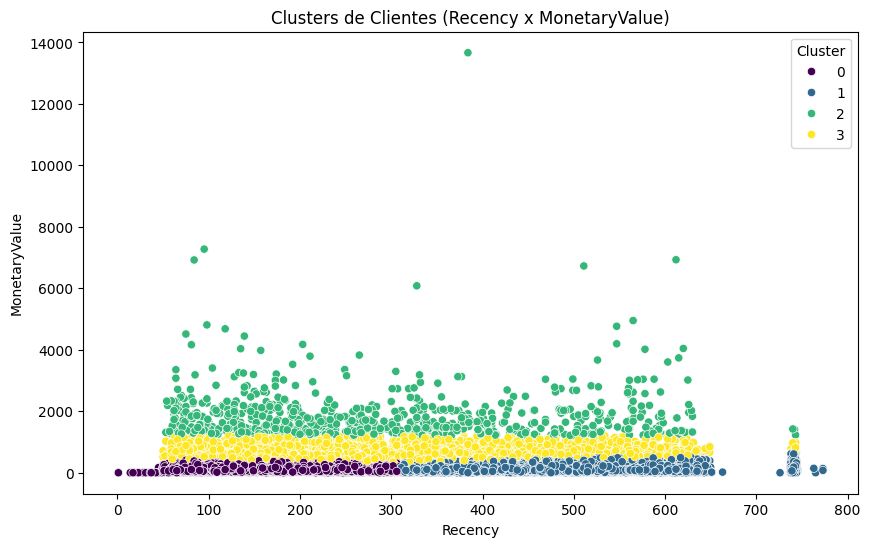

In [11]:

# Analisa as características de cada cluster
print("\nCaracterísticas dos Clusters:")
print(rfv.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'MonetaryValue': ['mean', 'median']
}))


# Visualizando os clusters (exemplo com Recency x Frequency)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfv, palette='viridis')
plt.title('Clusters de Clientes (Recency x Frequency)')
plt.show()


# Visualizando os clusters (exemplo com MonetaryValue x Frequency)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MonetaryValue', y='Frequency', hue='Cluster', data=rfv, palette='viridis')
plt.title('Clusters de Clientes (MonetaryValue x Frequency)')
plt.show()


# Visualizando os clusters (exemplo com Recency x MonetaryValue)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='MonetaryValue', hue='Cluster', data=rfv, palette='viridis')
plt.title('Clusters de Clientes (Recency x MonetaryValue)')
plt.show()

Cluster 0: Recency baixa, Frequency alta, Monetary Value alto. Este cluster pode representar os clientes mais valiosos, que compram frequentemente e recentemente. Devem ser recompensados com ofertas exclusivas e programas de fidelidade.

Cluster 1: Recency alta, Frequency baixa, Monetary Value baixo. Este cluster pode representar clientes em risco de churn, que não compram há muito tempo e gastam pouco. Campanhas de reativação e ofertas personalizadas podem ser eficazes.

Cluster 2: Recency média, Frequency média, Monetary Value médio. Este cluster pode representar os clientes "típicos", que compram ocasionalmente. Campanhas de up-selling e cross-selling podem ser interessantes.

Cluster 3: Recency baixa, Frequency baixa, Monetary Value baixo. Este cluster pode representar clientes novos ou esporádicos. É importante incentivá-los a comprar novamente e aumentar seu valor monetário.

## Considerando outra variável

In [ ]:
# 1. Merge para obter customer_unique_id em order_items
order_items_with_customer = pd.merge(order_items, orders[['order_id', 'customer_id']], on='order_id', how='left')
order_items_with_customer = pd.merge(order_items_with_customer, customers[['customer_id', 'customer_unique_id']], on='customer_id', how='left')


# 2. Merge para obter as categorias dos produtos
order_items_with_category = pd.merge(order_items_with_customer, products[['product_id', 'product_category_name']], on='product_id', how='left')


# 3. Encontra a categoria mais comprada por cliente (agora com customer_unique_id)
most_frequent_category = order_items_with_category.groupby(['customer_unique_id', 'product_category_name'])['order_id'].count().reset_index()
most_frequent_category = most_frequent_category.groupby('customer_unique_id').apply(lambda x: x.nlargest(1, 'order_id'))
most_frequent_category.reset_index(drop=True, inplace=True)
most_frequent_category = most_frequent_category[['customer_unique_id','product_category_name']]

most_frequent_category = most_frequent_category.rename(columns={'product_category_name': 'MostFrequentCategory'})


# 4. Adiciona a categoria mais frequente ao dataframe RFV (usando customer_unique_id)
rfv = pd.merge(rfv, most_frequent_category, on='customer_unique_id', how='left')


# Determina o número ideal de clusters (método Elbow)
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(rfv_scaled)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método Elbow para Determinar o Número de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()

# Escolhe o número de clusters baseado no gráfico do Elbow (exemplo: 4 clusters)
n_clusters = 4 # modifique se o gráfico elbow indicar outro valor ideal

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
rfv['Cluster'] = kmeans.fit_predict(rfv_scaled)

print(rfv.head())


# Analisando os clusters, incluindo a categoria mais frequente:
print(rfv.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'MonetaryValue': ['mean', 'median'],
    'MostFrequentCategory': lambda x: x.value_counts().index[0]  # Categoria mais frequente em cada cluster
}))